In [105]:
import torch
from torch import nn
from einops import rearrange

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler,autocast
import torch.optim as optim

import sys
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split

In [106]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [107]:
root_path = r"/home/srikanth/Dataset/Hit-GPRec-merged"
dataset_path = os.listdir(root_path)

In [108]:
class_labels = []
for item in dataset_path:
    #print(item)
    all_classes = os.listdir(root_path + '/' +item)
    for top_object in all_classes:
        sub_objects = os.listdir(root_path  + '/' +item + '/' +top_object)
        for sub_object in sub_objects:
            class_labels.append((item,str(root_path + '/' +item + '/' +top_object + '/' +sub_object)))
            
df = pd.DataFrame(data=class_labels, columns=['labels', 'image'])
y=list(df['labels'].values)
image=df['image']

In [109]:
images, y= shuffle(image,y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(images, y, test_size=0.2, random_state=415)
test_x = test_x.reset_index(drop=True)
train_x = train_x.reset_index(drop=True)
test_x, val_x, test_y, val_y = train_test_split(test_x,test_y, test_size=0.5, random_state=415)
test_x = test_x.reset_index(drop=True)
#train_y=list(train_y)
train_df=pd.DataFrame({'filepaths':train_x,'labels':train_y})
valid_df=pd.DataFrame({'filepaths':val_x,'labels':val_y})
test_df=pd.DataFrame({'filepaths':test_x,'labels':test_y})

In [110]:
classes=list(train_df['labels'].unique())
class_count=len(classes)

In [111]:
labels = df['labels'].unique()
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'Palmar wrist pronated': 0, 'Pinch': 1, 'Tripod': 2, 'Palmar wrist neutral': 3}
{0: 'Palmar wrist pronated', 1: 'Pinch', 2: 'Tripod', 3: 'Palmar wrist neutral'}


In [112]:
class ImageDataset():
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((63, 63), antialias=True),
        transforms.Normalize(mean=[0.74523671, 0.75350752, 0.73756239],
                             std=[0.23549667, 0.23590666, 0.25743267])
        ])
        self.label_mapping = label2id

    def __len__(self):
        return len(self.df)

    def get_images(self, idx):
        return self.transform(Image.open(self.df.iloc[idx]['filepaths']))

    def get_labels(self, idx):
        label = self.df.iloc[idx]['labels']
        return torch.tensor(self.label_mapping[label], dtype=torch.long)

    def __getitem__(self, idx):
        train_images = self.get_images(idx)
        train_labels = self.get_labels(idx)

        return train_images, train_labels

In [113]:
train_dataset = ImageDataset(train_df, transform=transforms)
val_dataset = ImageDataset(valid_df, transform=transforms)
test_dataset = ImageDataset(test_df, transform=transforms)

In [114]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

MODEL

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.layers import DropPath, trunc_normal_

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=partial(nn.LayerNorm, eps=1e-6)):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class ConvBlock(nn.Module):

    def __init__(self, inplanes, outplanes, stride=1, res_conv=False, act_layer=nn.ReLU, groups=1,
                 norm_layer=partial(nn.BatchNorm2d, eps=1e-6), drop_block=None, drop_path=None):
        super(ConvBlock, self).__init__()

        expansion = 4
        med_planes = outplanes // expansion

        self.conv1 = nn.Conv2d(inplanes, med_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = norm_layer(med_planes)
        self.act1 = act_layer(inplace=True)

        self.conv2 = nn.Conv2d(med_planes, med_planes, kernel_size=3, stride=stride, groups=groups, padding=1, bias=False)
        self.bn2 = norm_layer(med_planes)
        self.act2 = act_layer(inplace=True)

        self.conv3 = nn.Conv2d(med_planes, outplanes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = norm_layer(outplanes)
        self.act3 = act_layer(inplace=True)

        if res_conv:
            self.residual_conv = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=stride, padding=0, bias=False)
            self.residual_bn = norm_layer(outplanes)

        self.res_conv = res_conv
        self.drop_block = drop_block
        self.drop_path = drop_path

    def zero_init_last_bn(self):
        nn.init.zeros_(self.bn3.weight)

    def forward(self, x, x_t=None, return_x_2=True):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act1(x)

        x = self.conv2(x) if x_t is None else self.conv2(x + x_t)
        x = self.bn2(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x2 = self.act2(x)

        x = self.conv3(x2)
        x = self.bn3(x)
        if self.drop_block is not None:
            x = self.drop_block(x)

        if self.drop_path is not None:
            x = self.drop_path(x)

        if self.res_conv:
            residual = self.residual_conv(residual)
            residual = self.residual_bn(residual)

        x += residual
        x = self.act3(x)

        if return_x_2:
            return x, x2
        else:
            return x


class FCUDown(nn.Module):
    """ CNN feature maps -> Transformer patch embeddings
    """

    def __init__(self, inplanes, outplanes, dw_stride, act_layer=nn.GELU,
                 norm_layer=partial(nn.LayerNorm, eps=1e-6)):
        super(FCUDown, self).__init__()
        self.dw_stride = dw_stride

        self.conv_project = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=1, padding=0)
        self.sample_pooling = nn.AvgPool2d(kernel_size=dw_stride, stride=dw_stride)

        self.ln = norm_layer(outplanes)
        self.act = act_layer()

    def forward(self, x, x_t):
        x = self.conv_project(x)  # [N, C, H, W]

        x = self.sample_pooling(x).flatten(2).transpose(1, 2)
        x = self.ln(x)
        x = self.act(x)

        x = torch.cat([x_t[:, 0][:, None, :], x], dim=1)

        return x


class FCUUp(nn.Module):
    """ Transformer patch embeddings -> CNN feature maps
    """

    def __init__(self, inplanes, outplanes, up_stride, act_layer=nn.ReLU,
                 norm_layer=partial(nn.BatchNorm2d, eps=1e-6),):
        super(FCUUp, self).__init__()

        self.up_stride = up_stride
        self.conv_project = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=1, padding=0)
        self.bn = norm_layer(outplanes)
        self.act = act_layer()

    def forward(self, x, H, W):
        B, _, C = x.shape
        # [N, 197, 384] -> [N, 196, 384] -> [N, 384, 196] -> [N, 384, 14, 14]
        x_r = x[:, 1:].transpose(1, 2).reshape(B, C, H, W)
        x_r = self.act(self.bn(self.conv_project(x_r)))

        return F.interpolate(x_r, size=(H * self.up_stride, W * self.up_stride))


class Med_ConvBlock(nn.Module):
    """ special case for Convblock with down sampling,
    """
    def __init__(self, inplanes, act_layer=nn.ReLU, groups=1, norm_layer=partial(nn.BatchNorm2d, eps=1e-6),
                 drop_block=None, drop_path=None):

        super(Med_ConvBlock, self).__init__()

        expansion = 4
        med_planes = inplanes // expansion

        self.conv1 = nn.Conv2d(inplanes, med_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = norm_layer(med_planes)
        self.act1 = act_layer(inplace=True)

        self.conv2 = nn.Conv2d(med_planes, med_planes, kernel_size=3, stride=1, groups=groups, padding=1, bias=False)
        self.bn2 = norm_layer(med_planes)
        self.act2 = act_layer(inplace=True)

        self.conv3 = nn.Conv2d(med_planes, inplanes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = norm_layer(inplanes)
        self.act3 = act_layer(inplace=True)

        self.drop_block = drop_block
        self.drop_path = drop_path

    def zero_init_last_bn(self):
        nn.init.zeros_(self.bn3.weight)

    def forward(self, x):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        if self.drop_block is not None:
            x = self.drop_block(x)

        if self.drop_path is not None:
            x = self.drop_path(x)

        x += residual
        x = self.act3(x)

        return x


class ConvTransBlock(nn.Module):
    """
    Basic module for ConvTransformer, keep feature maps for CNN block and patch embeddings for transformer encoder block
    """

    def __init__(self, inplanes, outplanes, res_conv, stride, dw_stride, embed_dim, num_heads=12, mlp_ratio=4.,
                 qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
                 last_fusion=False, num_med_block=0, groups=1):

        super(ConvTransBlock, self).__init__()
        expansion = 4
        self.cnn_block = ConvBlock(inplanes=inplanes, outplanes=outplanes, res_conv=res_conv, stride=stride, groups=groups)

        if last_fusion:
            self.fusion_block = ConvBlock(inplanes=outplanes, outplanes=outplanes, stride=2, res_conv=True, groups=groups)
        else:
            self.fusion_block = ConvBlock(inplanes=outplanes, outplanes=outplanes, groups=groups)

        if num_med_block > 0:
            self.med_block = []
            for i in range(num_med_block):
                self.med_block.append(Med_ConvBlock(inplanes=outplanes, groups=groups))
            self.med_block = nn.ModuleList(self.med_block)

        self.squeeze_block = FCUDown(inplanes=outplanes // expansion, outplanes=embed_dim, dw_stride=dw_stride)

        self.expand_block = FCUUp(inplanes=embed_dim, outplanes=outplanes // expansion, up_stride=dw_stride)

        self.trans_block = Block(
            dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=drop_path_rate)

        self.dw_stride = dw_stride
        self.embed_dim = embed_dim
        self.num_med_block = num_med_block
        self.last_fusion = last_fusion

    def forward(self, x, x_t):
        x, x2 = self.cnn_block(x)

        _, _, H, W = x2.shape

        x_st = self.squeeze_block(x2, x_t)

        x_t = self.trans_block(x_st + x_t)

        if self.num_med_block > 0:
            for m in self.med_block:
                x = m(x)

        x_t_r = self.expand_block(x_t, H // self.dw_stride, W // self.dw_stride)
        x = self.fusion_block(x, x_t_r, return_x_2=False)

        return x, x_t

In [116]:
class Conformer(nn.Module):

    def __init__(self, patch_size=16, in_chans=3, num_classes=1000, base_channel=64, channel_ratio=4, num_med_block=0,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.):

        # Transformer
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        assert depth % 3 == 0

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.trans_dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule

        # Classifier head
        self.trans_norm = nn.LayerNorm(embed_dim)
        self.trans_cls_head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.conv_cls_head = nn.Linear(int(256 * channel_ratio), num_classes)

        # Stem stage: get the feature maps by conv block (copied form resnet.py)
        self.conv1 = nn.Conv2d(in_chans, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 1 / 2 [112, 112]
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 1 / 4 [56, 56]

        # 1 stage
        stage_1_channel = int(base_channel * channel_ratio)
        trans_dw_stride = patch_size // 4
        self.conv_1 = ConvBlock(inplanes=64, outplanes=stage_1_channel, res_conv=True, stride=1)
        self.trans_patch_conv = nn.Conv2d(64, embed_dim, kernel_size=trans_dw_stride, stride=trans_dw_stride, padding=0)
        self.trans_1 = Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                             qk_scale=qk_scale, drop=drop_rate, attn_drop=attn_drop_rate, drop_path=self.trans_dpr[0],
                             )

        # 2~4 stage
        init_stage = 2
        fin_stage = depth // 3 + 1
        for i in range(init_stage, fin_stage):
            self.add_module('conv_trans_' + str(i),
                    ConvTransBlock(
                        stage_1_channel, stage_1_channel, False, 1, dw_stride=trans_dw_stride, embed_dim=embed_dim,
                        num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=self.trans_dpr[i-1],
                        num_med_block=num_med_block
                    )
            )


        stage_2_channel = int(base_channel * channel_ratio * 2)
        # 5~8 stage
        init_stage = fin_stage # 5
        fin_stage = fin_stage + depth // 3 # 9
        for i in range(init_stage, fin_stage):
            s = 2 if i == init_stage else 1
            in_channel = stage_1_channel if i == init_stage else stage_2_channel
            res_conv = True if i == init_stage else False
            self.add_module('conv_trans_' + str(i),
                    ConvTransBlock(
                        in_channel, stage_2_channel, res_conv, s, dw_stride=trans_dw_stride // 2, embed_dim=embed_dim,
                        num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=self.trans_dpr[i-1],
                        num_med_block=num_med_block
                    )
            )

        stage_3_channel = int(base_channel * channel_ratio * 2 * 2)
        # 9~12 stage
        init_stage = fin_stage  # 9
        fin_stage = fin_stage + depth // 3  # 13
        for i in range(init_stage, fin_stage):
            s = 2 if i == init_stage else 1
            in_channel = stage_2_channel if i == init_stage else stage_3_channel
            res_conv = True if i == init_stage else False
            last_fusion = True if i == depth else False
            self.add_module('conv_trans_' + str(i),
                    ConvTransBlock(
                        in_channel, stage_3_channel, res_conv, s, dw_stride=trans_dw_stride // 4, embed_dim=embed_dim,
                        num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=self.trans_dpr[i-1],
                        num_med_block=num_med_block, last_fusion=last_fusion
                    )
            )
        self.fin_stage = fin_stage

        trunc_normal_(self.cls_token, std=.02)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1.)
            nn.init.constant_(m.bias, 0.)
        elif isinstance(m, nn.GroupNorm):
            nn.init.constant_(m.weight, 1.)
            nn.init.constant_(m.bias, 0.)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token'}


    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)

        # pdb.set_trace()
        # stem stage [N, 3, 224, 224] -> [N, 64, 56, 56]
        x_base = self.maxpool(self.act1(self.bn1(self.conv1(x))))

        # 1 stage
        x = self.conv_1(x_base, return_x_2=False)

        x_t = self.trans_patch_conv(x_base).flatten(2).transpose(1, 2)
        x_t = torch.cat([cls_tokens, x_t], dim=1)
        x_t = self.trans_1(x_t)
        
        # 2 ~ final 
        for i in range(2, self.fin_stage):
            x, x_t = eval('self.conv_trans_' + str(i))(x, x_t)

        # conv classification
        x_p = self.pooling(x).flatten(1)
        conv_cls = self.conv_cls_head(x_p)

        # trans classification
        x_t = self.trans_norm(x_t)
        tran_cls = self.trans_cls_head(x_t[:, 0])

        return [conv_cls, tran_cls]

In [117]:
model = Conformer(patch_size=16, channel_ratio=6, embed_dim=576, depth=12,
                      num_heads=9, mlp_ratio=4, qkv_bias=True)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001,  weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
num_epochs = 2


In [118]:
import torch

def trainVal(model, criterion, optimizer, num_epochs, min_val_loss, train_loader, val_loader, device):
    best_acc = 0.0
    min_loss = min_val_loss

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            if isinstance(outputs, list):
                loss_list = [criterion(o, labels) / len(outputs) for o in outputs]
                loss = sum(loss_list)
                # Combine predictions if needed (e.g., for ensembling)
                preds = torch.max(outputs[0] + outputs[1], 1)[1]  # Example: summing logits
            else:
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate loss
                if isinstance(outputs, list):
                    loss_list = [criterion(o, labels) / len(outputs) for o in outputs]
                    loss = sum(loss_list)
                    # Combine predictions if needed (e.g., for ensembling)
                    preds = torch.max(outputs[0] + outputs[1], 1)[1]  # Example: summing logits
                else:
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)

        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc)
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Save the model if it has the best validation accuracy so far
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            state = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'min_loss': epoch_loss
            }
            torch.save(state, 'weight/conformer-wwc-hitgprec.pth')

    return train_losses, train_accs, val_losses, val_accs, min_loss


In [119]:
# Define the initial minimum validation loss
# if epoch_acc > best_acc:
            # best_acc = epoch_acc
            # state = {
                # 'epoch': epoch + 1,
                # 'state_dict': model.state_dict(),
                # 'optimizer': optimizer.state_dict(),
                # 'min_loss': epoch_loss
            # }
        # torch.save(state, 'weight/conformer-wwc-hitgprec.pth')
min_val_loss = float('inf')

# Call the training function with the appropriate data loaders
train_losses, train_accs, val_losses, val_accs, min_loss = trainVal(
    model, criterion, optimizer, num_epochs, min_val_loss, train_loader, val_loader, device
)

Epoch 0/1
----------
Train Loss: 0.6117 Acc: 0.8154
Val Loss: 0.3192 Acc: 0.9238
Epoch 1/1
----------
Train Loss: 0.3210 Acc: 0.9147
Val Loss: 0.2584 Acc: 0.9337


/tmp/ipykernel_6771/2458496525.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses = torch.tensor(train_losses)
/tmp/ipykernel_6771/2458496525.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_losses = torch.tensor(val_losses)
/tmp/ipykernel_6771/2458496525.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_accs = torch.tensor(train_accs)
/tmp/ipykernel_6771/2458496525.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

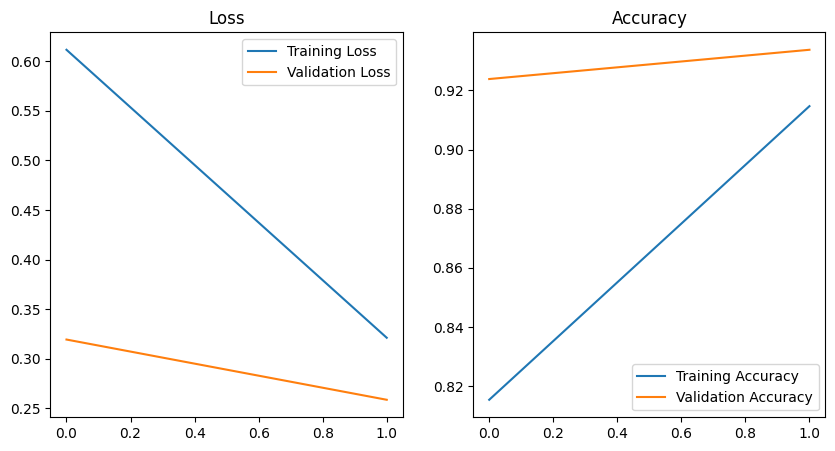

In [121]:
import matplotlib.pyplot as plt

# Convert the tensors to NumPy arrays

train_losses = torch.tensor(train_losses)
val_losses = torch.tensor(val_losses)
train_accs = torch.tensor(train_accs)
val_accs = torch.tensor(val_accs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [124]:
import torch


test_losses = []
test_accuracies = []

all_preds = []
all_labels = []

model.eval()
total_test_loss = 0.0
correct_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Calculate loss
        if isinstance(outputs, list):
            loss_list = [criterion(o, labels) / len(outputs) for o in outputs]
            test_loss = sum(loss_list)
            # Combine predictions if needed (e.g., for ensembling)
            preds = torch.max(outputs[0] + outputs[1], 1)[1]  # Example: summing logits
        else:
            test_loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1, keepdim=True)

        # Compute total test loss
        total_test_loss += test_loss.item() * images.size(0)

        # Compute accuracy
        correct_test += preds.eq(labels.view_as(preds)).sum().item()

        # Gather predictions and true labels for confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate average test loss and accuracy
average_test_loss = total_test_loss / len(test_loader.dataset)
test_accuracy = 100. * correct_test / len(test_loader.dataset)

test_losses.append(average_test_loss)
test_accuracies.append(test_accuracy)

print("Test Loss: {:.4f}".format(average_test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy))

# return test_losses, test_accuracies, all_preds, all_labels


Test Loss: 0.2629
Test Accuracy: 93.20%


In [125]:
from sklearn.metrics import confusion_matrix, classification_report
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)
# Classification Report
class_report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[ 399    0   23    0]
 [   1  975   19    0]
 [  33   45 2254   13]
 [  16   18  155  801]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       422
           1       0.94      0.98      0.96       995
           2       0.92      0.96      0.94      2345
           3       0.98      0.81      0.89       990

    accuracy                           0.93      4752
   macro avg       0.93      0.92      0.93      4752
weighted avg       0.93      0.93      0.93      4752

